### Mastercode for main figures of Acosta et al. (2024) 
### Article title "Climate conundrum: a wet or dry European and Northern African climate during the middle Miocene" 
### Journal AGU Geophysical Research Letters.


In [2]:
# Import Packages
import os
import pandas as pd
import numpy as np
import Ngl
import xesmf as xe
#import Nio
import xarray as xr
import netCDF4 as nc
import time
import pandas as pd
import math
import BiasRMSE as BRMSB
import BiasRMSE_Biasonly as BIASONLY

#plotting packages
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.util as cutil
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import geocat as gc
import geocat.viz as gv
import cmaps

### MAP & MAT Model-data Analysis

In [3]:
DIR = "{Insert_Directory}"
ds = xr.open_dataset(DIR+"Miocene_EuropeManuscript_Acostaetal2024-AnnualMean.nc")

In [27]:
rawlat = ds.lat
rawlon = ds.lon

pr_Mio400NAZM = ds.pr[0,:,:]
pr_Mio400 = ds.pr[1,:,:]
pr_Mio840 = ds.pr[2,:,:]

ts_Mio400NAZM = ds.ts[0,:,:]
ts_Mio400 = ds.ts[1,:,:]
ts_Mio840 = ds.ts[2,:,:]

In [29]:
#Convert to 1 degree

#Regrid Temp
Res1deg = xr.Dataset({'lat': (['lat'], np.linspace(-90,90,180)),'lon': (['lon'], np.linspace(0,360,360)),})
regridder = xe.Regridder(pr_Mio400, Res1deg, 'bilinear', periodic= True)

lat = Res1deg.lat
lon = Res1deg.lon

pr_Mio400_1deg = regridder(pr_Mio400)
pr_Mio840_1deg = regridder(pr_Mio840)
pr_Mio400NAZM_1deg = regridder(pr_Mio400NAZM)

ts_Mio400_1deg = regridder(ts_Mio400)
ts_Mio840_1deg = regridder(ts_Mio840)
ts_Mio400NAZM_1deg = regridder(ts_Mio400NAZM)

In [31]:
#Concatenate variables

prANNset = xr.Dataset({'pr_Mio400': xr.DataArray(pr_Mio400_1deg[:,:],dims = ['lat','lon'],coords = {'lat': lat, 'lon': lon},),
                         'pr_Mio840': xr.DataArray(pr_Mio840_1deg[:,:],dims = ['lat','lon'],coords = {'lat': lat, 'lon': lon},),
                         'pr_Mio400NAZM': xr.DataArray(pr_Mio400NAZM_1deg[:,:],dims = ['lat','lon'],coords = {'lat': lat, 'lon': lon},), 
                        },
    attrs = {'Global_attr': 'Created by PA 2023'}
    )
prANNsetary = prANNset.to_array()
prANNset1=prANNsetary.rename({'variable': 'exp,'})

tsANNset = xr.Dataset({'ts_Mio400': xr.DataArray(ts_Mio400_1deg[:,:],dims = ['lat','lon'],coords = {'lat': lat, 'lon': lon},),
                       'ts_Mio840': xr.DataArray(ts_Mio840_1deg[:,:],dims = ['lat','lon'],coords = {'lat': lat, 'lon': lon},),
                       'ts_Mio400NAZM': xr.DataArray(ts_Mio400NAZM_1deg[:,:],dims = ['lat','lon'],coords = {'lat': lat, 'lon': lon},),
                        },
    attrs = {'Global_attr': 'Created by PA 2023'}
    )
tsANNsetary = tsANNset.to_array()
tsANNset1=tsANNsetary.rename({'variable': 'exp,'})

In [17]:
# Annual Analysis
# Bring in MAP proxy

path = '{Insert_Directory}'
MMIO_MAP = pd.read_csv(path+"MioMIP_MAP_compilation_11122.csv",header=0, sep=',')

#Groupby
Destdata = MMIO_MAP.groupby("Sort_1L_2EM")
Dest1L = Destdata.get_group(1)
Dest2EM = Destdata.get_group(2)

# Change Dataframe to Dataarray
DestEU = Dest2EM[(30. <= Dest2EM['Palaeo_lat']) & (60. >= Dest2EM['Palaeo_lat']) 
                 & (Dest2EM['Palaeo_360_long'] >= -10.) & (Dest2EM['Palaeo_360_long'] <= 40.)]
MMIO_MAPv2 = DestEU.values[:,:]
MIOMAP = np.asarray(MMIO_MAPv2[:,1],dtype=np.float64)
MIOerr = np.asarray(MMIO_MAPv2[:,2],dtype=np.float64)
MIOLat = np.asarray(MMIO_MAPv2[:,3],dtype=np.float64)
MIOLon = np.asarray(MMIO_MAPv2[:,5],dtype=np.float64)
MIOMAPmin = MIOMAP-MIOerr
MIOMAPmax = MIOMAP+MIOerr

In [18]:
path = '{Insert_Directory}'
MMIO_MAT = pd.read_csv(path+"MioMIP_MAST_02282023.csv",header=0, sep=',')

#Groupby
Destdata1 = MMIO_MAT.groupby("Sort_1L_2EM")
Dest1L1 = Destdata1.get_group(1)
Dest2EM1 = Destdata1.get_group(2)

# Change Dataframe to Dataarray
DestEU1 = Dest2EM1[(30. <= Dest2EM1['Palaeo_lat']) & (60. >= Dest2EM1['Palaeo_lat']) 
                 & (Dest2EM1['Pal_360_long'] >= -10.) & (Dest2EM1['Pal_360_long'] <= 40.)]
MMIO_MATv2 = DestEU1 .values[:,:]
MIOMAT = np.asarray(MMIO_MATv2[:,0],dtype=np.float64)
MIOMATerr = np.asarray(MMIO_MATv2[:,1],dtype=np.float64)
MIOMATLat = np.asarray(MMIO_MATv2[:,2],dtype=np.float64)
MIOMATLon = np.asarray(MMIO_MATv2[:,4],dtype=np.float64)
MIOMATmin = MIOMAT-MIOMATerr
MIOMATmax = MIOMAT+MIOMATerr

In [19]:
MMIO_SST = pd.read_csv(path+"MidMiocene_SST_v3.csv",header=0, sep=',')

# Change Dataframe to Dataarray
MMIO_SSTv2 = MMIO_SST.values[:,:]
MIOSST = np.asarray(MMIO_SSTv2[:,1],dtype=np.float64)
MIOSSTerr = np.asarray(MMIO_SSTv2[:,2],dtype=np.float64)
MIOSSTLat = np.asarray(MMIO_SSTv2[:,3],dtype=np.float64)
MIOSSTLon = np.asarray(MMIO_SSTv2[:,5],dtype=np.float64)
MIOSSTmin = MIOSST-MIOSSTerr
MIOSSTmax = MIOSST+MIOSSTerr

In [20]:
MMIO_MAPHP = pd.read_csv(path+"MioMIP_MAT_herpetologicalData.csv",header=0, sep=',')

# Change Dataframe to Dataarray
MMIO_MAPHPv2 = MMIO_MAPHP.values[:,:]
MIOMAPHP = np.asarray(MMIO_MAPHPv2[:,0],dtype=np.float64)
MIOMAPerrHP = np.asarray(MMIO_MAPHPv2[:,1],dtype=np.float64)
MIOMAPLatHP = np.asarray(MMIO_MAPHPv2[:,2],dtype=np.float64)
MIOMAPLonHP = np.asarray(MMIO_MAPHPv2[:,3],dtype=np.float64)
MIOMAPminHP = MIOMAPHP-MIOMAPerrHP
MIOMAPmaxHP = MIOMAPHP+MIOMAPerrHP

In [21]:
# New CREST dataset
# Bring in MAP & MAT proxy
MMIO_MPound_MAT = pd.read_csv(path+"Pound2023_MAT.csv",header=0, sep=',')
MMIO_MPound_MAP = pd.read_csv(path+"Pound2023_MAP.csv",header=0, sep=',')

In [22]:
# Change Dataframe to Dataarray
MAPv3_values = MMIO_MPound_MAP.values[:,:]
MAPv3 = np.asarray(MAPv3_values[:,3],dtype=np.float64)
MAPv3errmin = np.asarray(MAPv3_values[:,4],dtype=np.float64)
MAPv3errmax = np.asarray(MAPv3_values[:,5],dtype=np.float64)
MAPv3Lat = np.asarray(MAPv3_values[:,0],dtype=np.float64)
MAPv3Lon = np.asarray(MAPv3_values[:,2],dtype=np.float64)

In [23]:
# Change Dataframe to Dataarray
MATv3_values = MMIO_MPound_MAT.values[:,:]
MATv3 = np.asarray(MATv3_values[:,3],dtype=np.float64)
MATv3errmin = np.asarray(MATv3_values[:,4],dtype=np.float64)
MATv3errmax = np.asarray(MATv3_values[:,5],dtype=np.float64)
MATv3Lat = np.asarray(MATv3_values[:,0],dtype=np.float64)
MATv3Lon = np.asarray(MATv3_values[:,2],dtype=np.float64)

In [24]:
#Read in updated Herold boundary conditions for plotting. See Burls et al. (2021)
MioMIPDIR = "{Insert_Directory}"
filename='miocene_topo_pollard_antscape_dolan_0.5x0.5.nc'
Herold_updated=xr.open_dataset(MioMIPDIR+filename,decode_times=False)
topo = Herold_updated.topo

In [32]:
#See Bias and RMSE Modules
#Precip RMSB Analysis 

#Paleobotanical Annual Precipitation Bias RMSE Europe 
PB_EUBRMB = BRMSB.BiasAnalysis(prANNset1,MIOMAP,MIOLat,MIOLon,MIOMAPmin,MIOMAPmax)

#Herpetelogical Annual Precipitation Bias RMSE Europe
HP_EUBRMB = BRMSB.BiasAnalysis(prANNset1,MIOMAPHP,MIOMAPLatHP,MIOMAPLonHP,MIOMAPminHP,MIOMAPmaxHP)

#New Paleobot Annual Precipitation Bias RMSE Europe
PBnew_EUBRMB = BRMSB.BiasAnalysis(prANNset1,MAPv3,MAPv3Lat,MAPv3Lon,MAPv3errmin,MAPv3errmax)

[349.86337476 352.57328265  90.26709609]
[153.60125215 141.70147669 242.16459343]
[221.22112372 238.69537582 117.2680814 ]


In [33]:
#Temp RMSB Analysis 

#Paleobotanical Annual Precipitation Bias RMSE Europe 
TB_EUBRMB = BRMSB.BiasAnalysis(tsANNset1,MIOMAT,MIOMATLat,MIOMATLon,MIOMATmin,MIOMATmax)

#New Paleobot Annual Precipitation Bias RMSE Europe
TBnew_EUBRMB = BRMSB.BiasAnalysis(tsANNset1,MATv3,MATv3Lat,MATv3Lon,MATv3errmin,MATv3errmax)


[2.0797296  2.14406777 1.91065911]
[4.47074355 6.7851421  6.68876122]


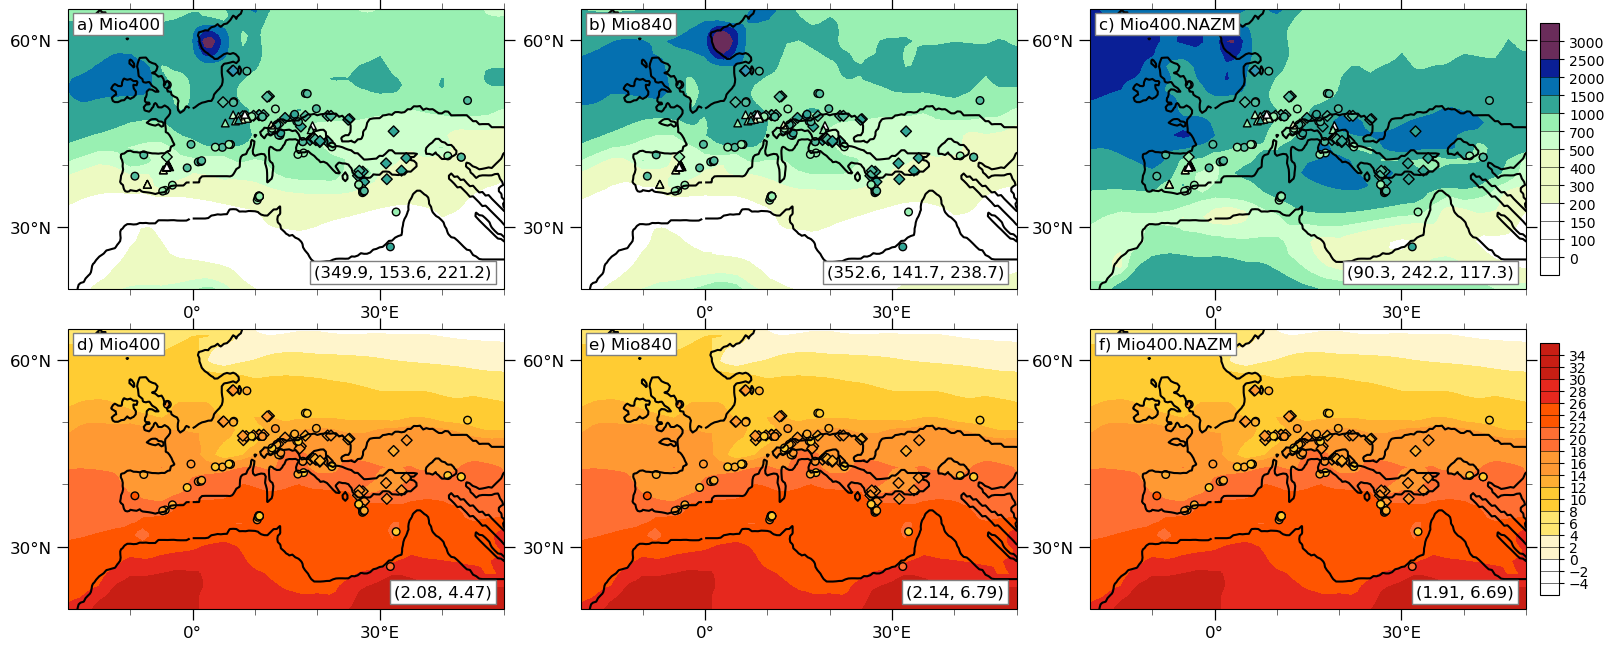

In [34]:
# Generate figure (set its size (width, height) in inches)
fig = plt.figure(figsize=(16, 12),layout="constrained")


# Create gridspec to hold six subplots
grid = fig.add_gridspec(ncols=3, nrows=4)
# Choose the map projection
proj = ccrs.PlateCarree()

# Add the subplots
ax1 = fig.add_subplot(grid[0,0], projection=proj)  # upper cell of grid
ax2 = fig.add_subplot(grid[0,1], projection=proj)  # middle cell of grid
ax3 = fig.add_subplot(grid[0,2], projection=proj)  # upper cell of grid
ax4 = fig.add_subplot(grid[1,0], projection=proj)  # lower cell of grid
ax5 = fig.add_subplot(grid[1,1], projection=proj)  # lower cell of grid
ax6 = fig.add_subplot(grid[1,2], projection=proj)  # lower cell of grid

# Customize plots to match NCL standard format
for (ax, title) in [(ax1, 'Mio400 Control'), (ax2, 'Mio400 NAZM'),
                    (ax3, 'Mio400 Control'), (ax4,'Mio400 NAZM'),
                   (ax5, 'Mio400 Control'), (ax6, 'Mio400 NAZM')]:
    # Use geocat.viz.util convenience function to set axes tick values
    gv.set_axes_limits_and_ticks(ax=ax,
                                 xlim=(-20, 50),
                                 ylim=(20, 65),
                                 xticks=np.linspace(-180, 180, 13),
                                 yticks=np.linspace(-90, 90, 7))

    # Use geocat.viz.util convenience function to make plots look like NCL
    # plots by using latitude, longitude tick labels
    gv.add_lat_lon_ticklabels(ax)

    # Remove the degree symbol from tick labels
    ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))
    ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol=''))

    # Use geocat.viz.util convenience function to add minor and major ticks
    gv.add_major_minor_ticks(ax)

    # Use geocat.viz.util convenience function to add minor and major tick lines
    gv.add_major_minor_ticks(ax, labelsize=12)
    gv.add_lat_lon_ticklabels(ax)
    

# misc
CNlevels = np.arange(0,3000,100) #Set contour levels
CNlevels2 = np.arange(-4,36,2) #Set contour levels
#cmap = plt.get_cmap('precip_11lev')# Colormap
newcmp = cmaps.precip_11lev # Colormap
newcmp2 = cmaps.sunshine_9lev 
#name = ["(a) MIDMIO400","(b) MIDMIO400_Idealized SST"] 
contour_levels = [0, 100, 150, 200, 300, 400, 500, 700, 1000, 1500, 2000, 2500,3000]
norm = mcolors.BoundaryNorm(boundaries=contour_levels, ncolors=14)

# Plot precip data
cyclic_data1, cyclic_lon1 = cutil.add_cyclic_point((pr_Mio400_1deg), coord=pr_Mio400_1deg.lon)
cyclic_data2, cyclic_lon2 = cutil.add_cyclic_point((pr_Mio840_1deg), coord=pr_Mio400_1deg.lon)
cyclic_data3, cyclic_lon3 = cutil.add_cyclic_point((pr_Mio400NAZM_1deg), coord=pr_Mio400_1deg.lon)


C = ax1.contourf(cyclic_lon1,pr_Mio400_1deg['lat'],cyclic_data1,levels = contour_levels,cmap=newcmp,extend='both')
ax2.contourf(cyclic_lon2,pr_Mio400_1deg['lat'],cyclic_data2,levels = contour_levels,cmap=newcmp,extend='both')
ax3.contourf(cyclic_lon3,pr_Mio400_1deg['lat'],cyclic_data3,levels = contour_levels,cmap=newcmp,extend='both')

#Paleobot
ax1.scatter( MIOLon,MIOLat, c=MIOMAP,marker='D', edgecolors='black',vmin=0, vmax=3000 , cmap=newcmp, s=30)
ax2.scatter( MIOLon,MIOLat, c=MIOMAP,marker='D', edgecolors='black',vmin=0, vmax=3000 , cmap=newcmp, s=30)
ax3.scatter( MIOLon,MIOLat, c=MIOMAP,marker='D', edgecolors='black',vmin=0, vmax=3000 , cmap=newcmp, s=30)

#PaleobotNew
ax1.scatter( MAPv3Lon,MAPv3Lat, c=MAPv3,marker='o', edgecolors='black',vmin=0, vmax=3000 , cmap=newcmp, s=30)
ax2.scatter( MAPv3Lon,MAPv3Lat, c=MAPv3,marker='o', edgecolors='black',vmin=0, vmax=3000 , cmap=newcmp, s=30)
ax3.scatter( MAPv3Lon,MAPv3Lat, c=MAPv3,marker='o', edgecolors='black',vmin=0, vmax=3000 , cmap=newcmp, s=30)

#Herp
ax1.scatter( MIOMAPLonHP,MIOMAPLatHP, c=MIOMAPHP,marker='^', edgecolors='black',vmin=0, vmax=3000 , cmap=newcmp, s=30)
ax2.scatter( MIOMAPLonHP,MIOMAPLatHP, c=MIOMAPHP,marker='^', edgecolors='black',vmin=0, vmax=3000 , cmap=newcmp, s=30)
ax3.scatter( MIOMAPLonHP,MIOMAPLatHP, c=MIOMAPHP,marker='^', edgecolors='black',vmin=0, vmax=3000 , cmap=newcmp, s=30)


# Plot TS data
cyclic_datats1, cyclic_lonts1 = cutil.add_cyclic_point((ts_Mio400_1deg), coord=pr_Mio400_1deg.lon)
cyclic_datats2, cyclic_lonts2 = cutil.add_cyclic_point((ts_Mio400_1deg), coord=pr_Mio400_1deg.lon)
cyclic_datats3, cyclic_lonts3 = cutil.add_cyclic_point((ts_Mio400_1deg), coord=pr_Mio400_1deg.lon)


C2 = ax4.contourf(cyclic_lonts1,pr_Mio400_1deg['lat'],cyclic_datats1,levels = CNlevels2,cmap=newcmp2,extend='both')
ax5.contourf(cyclic_lonts2,pr_Mio400_1deg['lat'],cyclic_datats2,levels = CNlevels2,cmap=newcmp2,extend='both')
ax6.contourf(cyclic_lonts3,pr_Mio400_1deg['lat'],cyclic_datats3,levels = CNlevels2,cmap=newcmp2,extend='both')

#TS
ax4.scatter( MIOMATLon,MIOMATLat, c=MIOMAT,marker='D', edgecolors='black',vmin=-4, vmax=36 , cmap=newcmp2, s=30)
ax5.scatter( MIOMATLon,MIOMATLat, c=MIOMAT,marker='D', edgecolors='black',vmin=-4, vmax=36 , cmap=newcmp2, s=30)
ax6.scatter( MIOMATLon,MIOMATLat, c=MIOMAT,marker='D', edgecolors='black',vmin=-4, vmax=36 , cmap=newcmp2, s=30)

#TSNew
ax4.scatter( MATv3Lon,MATv3Lat, c=MATv3,marker='o', edgecolors='black',vmin=-4, vmax=36 , cmap=newcmp2, s=30)
ax5.scatter( MATv3Lon,MATv3Lat, c=MATv3,marker='o', edgecolors='black',vmin=-4, vmax=36 , cmap=newcmp2, s=30)
ax6.scatter( MATv3Lon,MATv3Lat, c=MATv3,marker='o', edgecolors='black',vmin=-4, vmax=36 , cmap=newcmp2, s=30)

ax1.contour(Herold_updated.topo.lon,Herold_updated.topo.lat,Herold_updated.topo, levels=[0], colors='k', linestyles='-')
ax2.contour(Herold_updated.topo.lon,Herold_updated.topo.lat,Herold_updated.topo, levels=[0], colors='k', linestyles='-')
ax3.contour(Herold_updated.topo.lon,Herold_updated.topo.lat,Herold_updated.topo, levels=[0], colors='k', linestyles='-')
ax4.contour(Herold_updated.topo.lon,Herold_updated.topo.lat,Herold_updated.topo, levels=[0], colors='k', linestyles='-')
ax5.contour(Herold_updated.topo.lon,Herold_updated.topo.lat,Herold_updated.topo, levels=[0], colors='k', linestyles='-')
ax6.contour(Herold_updated.topo.lon,Herold_updated.topo.lat,Herold_updated.topo, levels=[0], colors='k', linestyles='-')



ax1.text(0.02,.93,'a) Mio400',horizontalalignment='left',transform=ax1.transAxes,fontsize=12,
              bbox=dict(boxstyle='square, pad=0.20',facecolor='white',edgecolor='gray'),zorder=5)

ax2.text(0.02,.93,'b) Mio840',horizontalalignment='left',transform=ax2.transAxes,fontsize=12,
              bbox=dict(boxstyle='square, pad=0.20',facecolor='white',edgecolor='gray'),zorder=5)

ax3.text(0.02,.93,'c) Mio400.NAZM',horizontalalignment='left',transform=ax3.transAxes,fontsize=12,
              bbox=dict(boxstyle='square, pad=0.20',facecolor='white',edgecolor='gray'),zorder=5)


ax4.text(0.02,.93,'d) Mio400',horizontalalignment='left',transform=ax4.transAxes,fontsize=12,
              bbox=dict(boxstyle='square, pad=0.20',facecolor='white',edgecolor='gray'),zorder=5)

ax5.text(0.02,.93,'e) Mio840',horizontalalignment='left',transform=ax5.transAxes,fontsize=12,
              bbox=dict(boxstyle='square, pad=0.20',facecolor='white',edgecolor='gray'),zorder=5)

ax6.text(0.02,.93,'f) Mio400.NAZM',horizontalalignment='left',transform=ax6.transAxes,fontsize=12,
              bbox=dict(boxstyle='square, pad=0.20',facecolor='white',edgecolor='gray'),zorder=5)

#Bias Analysis
ax1.text(48,22, (np.around(PB_EUBRMB[0],decimals=1),np.around(HP_EUBRMB[0],decimals=1),np.around(PBnew_EUBRMB[0],decimals=1)),
         horizontalalignment='right',fontsize=12,bbox=dict(boxstyle='square, pad=0.25',facecolor='white',edgecolor='gray'),)

ax2.text(48,22, (np.around(PB_EUBRMB[1],decimals=1),np.around(HP_EUBRMB[1],decimals=1),np.around(PBnew_EUBRMB[1],decimals=1)),
         horizontalalignment='right',fontsize=12,bbox=dict(boxstyle='square, pad=0.25',facecolor='white',edgecolor='gray'),)

ax3.text(48,22, (np.around(PB_EUBRMB[2],decimals=1),np.around(HP_EUBRMB[2],decimals=1),np.around(PBnew_EUBRMB[2],decimals=1)),
         horizontalalignment='right',fontsize=12,bbox=dict(boxstyle='square, pad=0.25',facecolor='white',edgecolor='gray'),)


ax4.text(48,22, (np.around(TB_EUBRMB[0],decimals=2),np.around(TBnew_EUBRMB[0],decimals=2)),
         horizontalalignment='right',fontsize=12,bbox=dict(boxstyle='square, pad=0.25',facecolor='white',edgecolor='gray'),)

ax5.text(48,22, (np.around(TB_EUBRMB[1],decimals=2),np.around(TBnew_EUBRMB[1],decimals=2)),
         horizontalalignment='right',fontsize=12,bbox=dict(boxstyle='square, pad=0.25',facecolor='white',edgecolor='gray'),)

ax6.text(48,22, (np.around(TB_EUBRMB[2],decimals=2),np.around(TBnew_EUBRMB[2],decimals=2)),
         horizontalalignment='right',fontsize=12,bbox=dict(boxstyle='square, pad=0.25',facecolor='white',edgecolor='gray'),)

cab1 = plt.colorbar(C,
                    ax=ax3,
                    ticks=contour_levels,
                    extendrect=True,
                    extendfrac='auto',
                    shrink=0.9,
                    aspect=13,
                    pad=0.03,
                    drawedges=True)
cab2 = plt.colorbar(C2,
                    ax=ax6,
                    ticks=CNlevels2,
                    extendrect=True,
                    extendfrac='auto',
                    shrink=0.9,
                    aspect=13,
                    pad=0.03,
                    drawedges=True)

plt.show()

In [35]:
#Precip Bias only Analysis 

#Paleobotanical Annual Precipitation Bias RMSE Europe 
PB_EUBRMB1 = BIASONLY.BiasAnalysis(prANNset1,MIOMAP,MIOLat,MIOLon,MIOMAPmin,MIOMAPmax)

#Herpetelogical Annual Precipitation Bias RMSE Europe
HP_EUBRMB1 = BIASONLY.BiasAnalysis(prANNset1,MIOMAPHP,MIOMAPLatHP,MIOMAPLonHP,MIOMAPminHP,MIOMAPmaxHP)

#New Paleobot Annual Precipitation Bias RMSE Europe

PBnew_EUBRMB1 = BIASONLY.BiasAnalysis(prANNset1,MAPv3,MAPv3Lat,MAPv3Lon,MAPv3errmin,MAPv3errmax)

In [36]:
#Temp Bias Analysis 

#Paleobotanical Annual Precipitation Bias RMSE Europe 
TB_EUBRMB1 = BIASONLY.BiasAnalysis(tsANNset1,MIOMAT,MIOMATLat,MIOMATLon,MIOMATmin,MIOMATmax)

#New Paleobot Annual Precipitation Bias RMSE Europe

TBnew_EUBRMB1 = BIASONLY.BiasAnalysis(tsANNset1,MATv3,MATv3Lat,MATv3Lon,MATv3errmin,MATv3errmax)


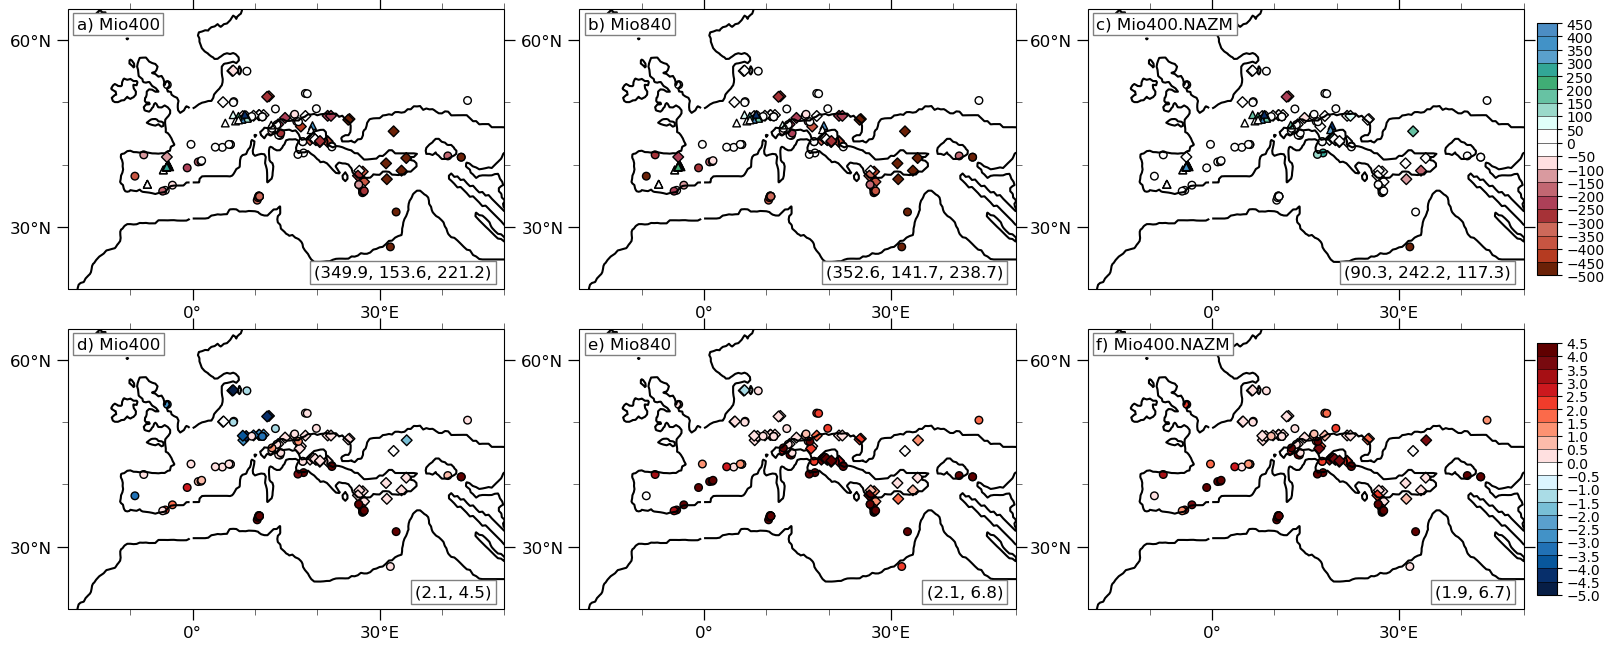

In [37]:
# Generate figure (set its size (width, height) in inches)
fig = plt.figure(figsize=(16, 12),layout="constrained")


# Create gridspec to hold six subplots
grid = fig.add_gridspec(ncols=3, nrows=4)

# Choose the map projection
proj = ccrs.PlateCarree()

# Add the subplots
ax1 = fig.add_subplot(grid[0,0], projection=proj)  # upper cell of grid
ax2 = fig.add_subplot(grid[0,1], projection=proj)  # middle cell of grid
ax3 = fig.add_subplot(grid[0,2], projection=proj)  # upper cell of grid
ax4 = fig.add_subplot(grid[1,0], projection=proj)  # lower cell of grid
ax5 = fig.add_subplot(grid[1,1], projection=proj)  # lower cell of grid
ax6 = fig.add_subplot(grid[1,2], projection=proj)  # lower cell of grid

# Customize plots to match NCL standard format
for (ax, title) in [(ax1, 'Mio400 Control'), (ax2, 'Mio400 NAZM'),
                    (ax3, 'Mio400 Control'), (ax4,'Mio400 NAZM'),
                   (ax5, 'Mio400 Control'), (ax6, 'Mio400 NAZM')]:
    # Use geocat.viz.util convenience function to set axes tick values
    gv.set_axes_limits_and_ticks(ax=ax,
                                 xlim=(-20, 50),
                                 ylim=(20, 65),
                                 xticks=np.linspace(-180, 180, 13),
                                 yticks=np.linspace(-90, 90, 7))

    # Use geocat.viz.util convenience function to make plots look like NCL
    # plots by using latitude, longitude tick labels
    gv.add_lat_lon_ticklabels(ax)

    # Remove the degree symbol from tick labels
    ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))
    ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol=''))

    # Use geocat.viz.util convenience function to add minor and major ticks
    gv.add_major_minor_ticks(ax)

    # Use geocat.viz.util convenience function to add minor and major tick lines
    gv.add_major_minor_ticks(ax, labelsize=12)
    gv.add_lat_lon_ticklabels(ax)
    

# misc
CNlevels = np.arange(-500,500,50) #Set contour levels
CNlevels2 = np.arange(-5,5,.5) #Set contour levels

newcmp = cmaps.precip4_diff_19lev # Colormap
newcmp2 = cmaps.temp_diff_18lev 

norm1 = mcolors.BoundaryNorm(boundaries=CNlevels, ncolors=19)
norm2 = mcolors.BoundaryNorm(boundaries=CNlevels2, ncolors=19)

#Paleobot
C = ax1.scatter( MIOLon,MIOLat, c=PB_EUBRMB1[0],marker='D', edgecolors='black',norm=norm1, cmap=newcmp, s=30)
ax2.scatter( MIOLon,MIOLat, c=PB_EUBRMB1[1],marker='D', edgecolors='black',norm=norm1 , cmap=newcmp, s=30)
ax3.scatter( MIOLon,MIOLat, c=PB_EUBRMB1[2] ,marker='D', edgecolors='black',norm=norm1 , cmap=newcmp, s=30)

#PaleobotNew
ax1.scatter( MAPv3Lon,MAPv3Lat, c=PBnew_EUBRMB1[0],marker='o', edgecolors='black',norm=norm1 , cmap=newcmp, s=30)
ax2.scatter( MAPv3Lon,MAPv3Lat, c=PBnew_EUBRMB1[1],marker='o', edgecolors='black',norm=norm1 , cmap=newcmp, s=30)
ax3.scatter( MAPv3Lon,MAPv3Lat, c=PBnew_EUBRMB1[2],marker='o', edgecolors='black',norm=norm1 , cmap=newcmp, s=30)

#Herp
ax1.scatter( MIOMAPLonHP,MIOMAPLatHP, c=HP_EUBRMB1[0],marker='^', edgecolors='black',norm=norm1, cmap=newcmp, s=30)
ax2.scatter( MIOMAPLonHP,MIOMAPLatHP, c=HP_EUBRMB1[1],marker='^', edgecolors='black',norm=norm1 , cmap=newcmp, s=30)
ax3.scatter( MIOMAPLonHP,MIOMAPLatHP, c=HP_EUBRMB1[2],marker='^', edgecolors='black',norm=norm1 , cmap=newcmp, s=30)

#TS
C2 = ax4.scatter( MIOMATLon,MIOMATLat, c=TB_EUBRMB1[0],marker='D', edgecolors='black',norm=norm2 , cmap=newcmp2, s=30)
ax5.scatter( MIOMATLon,MIOMATLat, c=TB_EUBRMB1[1],marker='D', edgecolors='black',norm=norm2 , cmap=newcmp2, s=30)
ax6.scatter( MIOMATLon,MIOMATLat, c=TB_EUBRMB1[2],marker='D', edgecolors='black',norm=norm2 , cmap=newcmp2, s=30)

#TSNew
ax4.scatter( MATv3Lon,MATv3Lat, c=TBnew_EUBRMB1[0],marker='o', edgecolors='black',norm=norm2 , cmap=newcmp2, s=30)
ax5.scatter( MATv3Lon,MATv3Lat, c=TBnew_EUBRMB1[1],marker='o', edgecolors='black',norm=norm2, cmap=newcmp2, s=30)
ax6.scatter( MATv3Lon,MATv3Lat, c=TBnew_EUBRMB1[2],marker='o', edgecolors='black',norm=norm2 , cmap=newcmp2, s=30)


ax1.contour(Herold_updated.topo.lon,Herold_updated.topo.lat,Herold_updated.topo, levels=[0], colors='k', linestyles='-')
ax2.contour(Herold_updated.topo.lon,Herold_updated.topo.lat,Herold_updated.topo, levels=[0], colors='k', linestyles='-')
ax3.contour(Herold_updated.topo.lon,Herold_updated.topo.lat,Herold_updated.topo, levels=[0], colors='k', linestyles='-')
ax4.contour(Herold_updated.topo.lon,Herold_updated.topo.lat,Herold_updated.topo, levels=[0], colors='k', linestyles='-')
ax5.contour(Herold_updated.topo.lon,Herold_updated.topo.lat,Herold_updated.topo, levels=[0], colors='k', linestyles='-')
ax6.contour(Herold_updated.topo.lon,Herold_updated.topo.lat,Herold_updated.topo, levels=[0], colors='k', linestyles='-')



ax1.text(0.02,.93,'a) Mio400',horizontalalignment='left',transform=ax1.transAxes,fontsize=12,
              bbox=dict(boxstyle='square, pad=0.20',facecolor='white',edgecolor='gray'),zorder=5)

ax2.text(0.02,.93,'b) Mio840',horizontalalignment='left',transform=ax2.transAxes,fontsize=12,
              bbox=dict(boxstyle='square, pad=0.20',facecolor='white',edgecolor='gray'),zorder=5)

ax3.text(0.02,.93,'c) Mio400.NAZM',horizontalalignment='left',transform=ax3.transAxes,fontsize=12,
              bbox=dict(boxstyle='square, pad=0.20',facecolor='white',edgecolor='gray'),zorder=5)


ax4.text(0.02,.93,'d) Mio400',horizontalalignment='left',transform=ax4.transAxes,fontsize=12,
              bbox=dict(boxstyle='square, pad=0.20',facecolor='white',edgecolor='gray'),zorder=5)

ax5.text(0.02,.93,'e) Mio840',horizontalalignment='left',transform=ax5.transAxes,fontsize=12,
              bbox=dict(boxstyle='square, pad=0.20',facecolor='white',edgecolor='gray'),zorder=5)

ax6.text(0.02,.93,'f) Mio400.NAZM',horizontalalignment='left',transform=ax6.transAxes,fontsize=12,
              bbox=dict(boxstyle='square, pad=0.20',facecolor='white',edgecolor='gray'),zorder=5)


#Bias Analysis
ax1.text(48,22, (np.around(PB_EUBRMB[0],decimals=1),np.around(HP_EUBRMB[0],decimals=1),np.around(PBnew_EUBRMB[0],decimals=1)),
         horizontalalignment='right',fontsize=12,bbox=dict(boxstyle='square, pad=0.25',facecolor='white',edgecolor='gray'),)

ax2.text(48,22, (np.around(PB_EUBRMB[1],decimals=1),np.around(HP_EUBRMB[1],decimals=1),np.around(PBnew_EUBRMB[1],decimals=1)),
         horizontalalignment='right',fontsize=12,bbox=dict(boxstyle='square, pad=0.25',facecolor='white',edgecolor='gray'),)

ax3.text(48,22, (np.around(PB_EUBRMB[2],decimals=1),np.around(HP_EUBRMB[2],decimals=1),np.around(PBnew_EUBRMB[2],decimals=1)),
         horizontalalignment='right',fontsize=12,bbox=dict(boxstyle='square, pad=0.25',facecolor='white',edgecolor='gray'),)


ax4.text(48,22, (np.around(TB_EUBRMB[0],decimals=1),np.around(TBnew_EUBRMB[0],decimals=1)),
         horizontalalignment='right',fontsize=12,bbox=dict(boxstyle='square, pad=0.25',facecolor='white',edgecolor='gray'),)

ax5.text(48,22, (np.around(TB_EUBRMB[1],decimals=1),np.around(TBnew_EUBRMB[1],decimals=1)),
         horizontalalignment='right',fontsize=12,bbox=dict(boxstyle='square, pad=0.25',facecolor='white',edgecolor='gray'),)

ax6.text(48,22, (np.around(TB_EUBRMB[2],decimals=1),np.around(TBnew_EUBRMB[2],decimals=1)),
         horizontalalignment='right',fontsize=12,bbox=dict(boxstyle='square, pad=0.25',facecolor='white',edgecolor='gray'),)

cab1 = plt.colorbar(C,
                    ax=ax3,
                    ticks=CNlevels,
                    extendrect=True,
                    extendfrac='auto',
                    shrink=0.9,
                    aspect=13,
                    pad=0.03,
                    drawedges=True)
cab2 = plt.colorbar(C2,
                    ax=ax6,
                    ticks=CNlevels2,
                    extendrect=True,
                    extendfrac='auto',
                    shrink=0.9,
                    aspect=13,
                    pad=0.03,
                    drawedges=True)


plt.show()

### Annual Mean Integrated Moisture Transport

In [4]:
#Read in updated Herold boundary conditions for figures. See Burls et al. (2021)
MioMIPDIR = "{Insert_Directory}"
filename='miocene_topo_pollard_antscape_dolan_0.5x0.5.nc'
Herold_updated=xr.open_dataset(MioMIPDIR+filename,decode_times=False)

In [5]:
IVT_Mio400NAZM = ds.ivt[0,:,:]
IVT_Mio400 = ds.ivt[1,:,:]
IVT_Mio840 = ds.ivt[2,:,:]

IVT_anomMio400 = IVT_Mio400NAZM - IVT_Mio400 
IVT_anomMio840 = IVT_Mio400NAZM - IVT_Mio840 

ev_Mio400NAZM = ds.evspsbl[0,:,:]
ev_Mio400 = ds.evspsbl[1,:,:]
ev_Mio840 = ds.evspsbl[2,:,:]

ev_anomMio400 = ev_Mio400NAZM - ev_Mio400 
ev_anomMio840 = ev_Mio400NAZM - ev_Mio840 

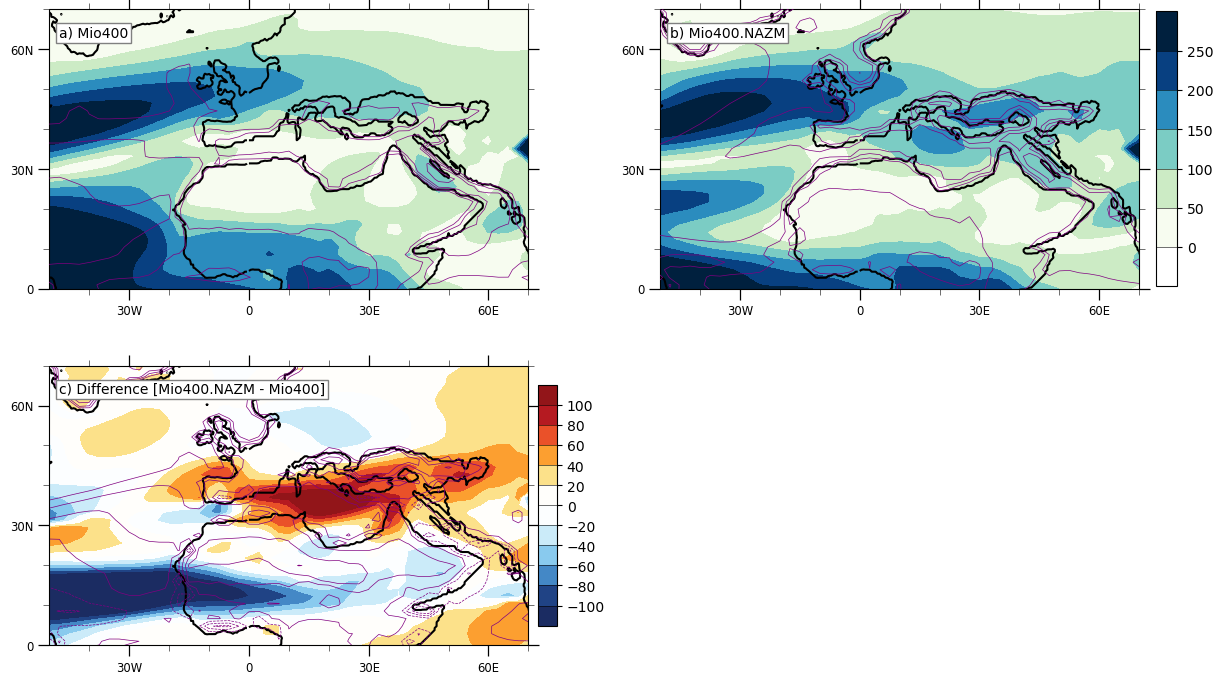

In [9]:
# Generate figure (set its size (width, height) in inches)
fig = plt.figure(figsize=(17, 14),layout="constrained")

# Create gridspec to hold six subplots
grid = fig.add_gridspec(ncols=3, nrows=4)

# Choose the map projection
proj = ccrs.PlateCarree()

# Add the subplots
ax1 = fig.add_subplot(grid[0,0], projection=proj)  # upper cell of grid
ax2 = fig.add_subplot(grid[0,1], projection=proj)  # middle cell of grid
ax3 = fig.add_subplot(grid[1,0], projection=proj)  # lower cell of grid



# Customize plots to match NCL standard format
for (ax, title) in [(ax1, 'Mio400 Control'), (ax2, 'Mio400 NAZM'),
                    (ax3, 'Difference')]:
    # Use geocat.viz.util convenience function to set axes tick values
    gv.set_axes_limits_and_ticks(ax=ax,
                                 xlim=(-50, 70),
                                 ylim=(0, 70),
                                 xticks=np.linspace(-180, 180, 13),
                                 yticks=np.linspace(-90, 90, 7))

    # Use geocat.viz.util convenience function to make plots look like NCL
    # plots by using latitude, longitude tick labels
    gv.add_lat_lon_ticklabels(ax)

    # Remove the degree symbol from tick labels
    ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))
    ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol=''))

    # Use geocat.viz.util convenience function to add minor and major ticks
    gv.add_major_minor_ticks(ax)

    ax.contour(Herold_updated.topo.lon,Herold_updated.topo.lat,Herold_updated.topo, levels=[0], colors='k', linestyles='-')

# misc
CNlevels = np.arange(0,300,50) #Set contour levels
anolevels = np.linspace(-100, 100, 11, endpoint=True)
evanolevels = np.linspace(-1000, 1000, 7, endpoint=True)
evlevels = np.arange(1000,3000,500)
#cmap = plt.get_cmap('precip_11lev')# Colormap
newcmp = cmaps.CBR_wet#cmocean_matter # Colormap
newcmp2 = cmaps.BlueWhiteOrangeRed
#name = ["(a) MIDMIO400","(b) MIDMIO_Idealized SST"] 
contour_levels = [0, 100, 150, 200, 300, 400, 500]
norm = mcolors.BoundaryNorm(boundaries=contour_levels, ncolors=14)

cyclic_data1, cyclic_lon1 = cutil.add_cyclic_point((IVT_Mio400), coord=IVT_Mio400.lon)
cyclic_data2, cyclic_lon2 = cutil.add_cyclic_point((IVT_Mio400NAZM), coord=IVT_Mio400.lon)
cyclic_data3, cyclic_lon3 = cutil.add_cyclic_point(IVT_anomMio400, coord=IVT_Mio400.lon)

#evANNanom ev_ANN_TEST
cyclic_evap1, cyclic_lon1 = cutil.add_cyclic_point((ev_Mio400), coord=IVT_Mio400.lon)
cyclic_evap2, cyclic_lon2 = cutil.add_cyclic_point((ev_Mio400NAZM), coord=IVT_Mio400.lon)
cyclic_evap3, cyclic_lon3 = cutil.add_cyclic_point(ev_anomMio400, coord=IVT_Mio400.lon)


# Plot Control cases
C = ax1.contourf(cyclic_lon1,IVT_Mio400.lat,cyclic_data1,levels = CNlevels,cmap=newcmp,extend='both')

ax1.contour(cyclic_lon1,IVT_Mio400.lat,cyclic_evap1,levels = evlevels,colors='purple',linewidths=0.5,zorder=3)


ax2.contourf(cyclic_lon2,IVT_Mio400.lat,cyclic_data2,levels = CNlevels,cmap=newcmp,extend='both')

ax2.contour(cyclic_lon2,IVT_Mio400.lat,cyclic_evap2,levels = evlevels,colors='purple',linewidths=0.5,zorder=3)



#Anomaly
C_2 = ax3.contourf(cyclic_lon3, IVT_Mio400.lat,cyclic_data3,levels = anolevels,cmap=newcmp2,extend='both')

ax3.contour(cyclic_lon3,IVT_Mio400.lat,cyclic_evap3,levels = evanolevels,colors='purple',linewidths=0.5,zorder=2)

                
cab1 = plt.colorbar(C,ax=ax2,ticks=CNlevels,extendrect=True,extendfrac='auto',shrink=.8,aspect=13,pad=0.05,drawedges=True,anchor=(2.5, .5))

cab2 = plt.colorbar(C_2,ax=ax3,ticks=anolevels,extendrect=True,extendfrac='auto',shrink=.7,aspect=13,pad=0.03,drawedges=True,anchor=(1.5, .5))

    
ax1.text(0.02,.90,'a) Mio400',horizontalalignment='left',transform=ax1.transAxes,fontsize=10,
              bbox=dict(boxstyle='square, pad=0.20',facecolor='white',edgecolor='gray'),zorder=5)

ax2.text(0.02,.90,'b) Mio400.NAZM',horizontalalignment='left',transform=ax2.transAxes,fontsize=10,
              bbox=dict(boxstyle='square, pad=0.20',facecolor='white',edgecolor='gray'),zorder=5)


ax3.text(0.02,.90,'c) Difference [Mio400.NAZM - Mio400]',horizontalalignment='left',transform=ax3.transAxes,fontsize=10,
              bbox=dict(boxstyle='square, pad=0.20',facecolor='white',edgecolor='gray'),zorder=5)

plt.show();